In [228]:
import glob
import numpy as np
import matplotlib.pyplot as plt

Raw mask shape:  (640, 480, 3)
Apple masks shape:  (307200, 3)


Text(0.5, 1.0, 'raw_masks[0]')

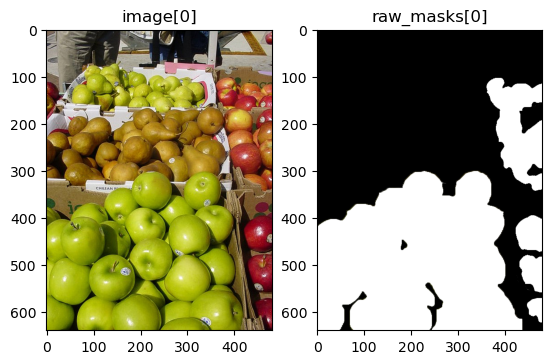

In [229]:
image_files = glob.glob("apples/*.jpg")
mask_files = glob.glob("apples/*.png")
image_files.sort()
mask_files.sort()

image_list = []
raw_masks = []
apple_masks = []
non_apple_masks = []

for cur_img in image_files:
    # load images
    image = plt.imread(cur_img)
    image_list.append(image)

for cur_mask in mask_files:
    # load masks
    raw = plt.imread(cur_mask)
    if raw.shape[-1] == 4:
        raw = np.delete(raw, -1, axis=-1)
    raw_masks.append(raw)


def mask_reshape(data):
    return np.float32(data.reshape(data.shape[0] * data.shape[1], data.shape[2]))

for mask in raw_masks:
    apple_masks.append(mask_reshape(mask))
    non_apple_masks.append(mask_reshape(1 - mask))
    
print("Raw mask shape: ", raw_masks[0].shape)
print("Apple masks shape: ", apple_masks[0].shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_list[0])
ax1.set_title('image[0]')
ax2.imshow(raw_masks[0])
ax2.set_title('raw_masks[0]')

In [230]:
MoG_params = dict()
MoG_params['k'] = 3
MoG_params['d'] = 3     # Use red, green, blue channels as dimensions
MoG_params['weight'] = np.array([])
MoG_params['mean'] = np.array([]).T
MoG_params['cov'] = np.array([])

In [231]:
def get_MoG_loglike(image, MoG_params):
    data = np.atleast_3d(image)
    pass

In [239]:
def fit_MoG_model(mask):
    # mask shape: (640,480)
    mean_mask = np.mean(mask, axis=0)
    cov_mask = np.cov(mask, rowvar=False)
    return mean_mask, cov_mask

In [240]:
mean_apple, cov_apple = fit_MoG_model(apple_masks[0])
print("Mean apple:", mean_apple)
print("Cov apple:", cov_apple)

mean_non_apple, cov_non_apple = fit_MoG_model(non_apple_masks[0])


Mean apple: [ 0.00014096  0.00012834 -0.0002693 ]
Cov apple: [[ 3.79143126e-06  3.27459528e-06 -7.06602653e-06]
 [ 3.27459528e-06  3.71942267e-06 -6.99401794e-06]
 [-7.06602653e-06 -6.99401794e-06  1.40600445e-05]]


In [241]:
def calculate_gaussian_prob(data, mean, cov):
    num_Data, _  = data.shape
    like = (1 / (((2 * np.pi)**(num_Data / 2)) * np.sqrt(np.linalg.det(cov)))) * np.exp(-0.5 * (data - mean.reshape(3,1)).T @ np.linalg.inv(cov) @ (data - mean.reshape(3,1)))
    return like

In [246]:
prior_apple = 0.9
prior_non_apple = 0.1
threshold = 0.5

test_image = image_list[0]
width, height, num_dims = test_image.shape
posterior_apple = np.zeros((width, height))
for i in range(width):
    print("Row: ", i)
    for j in range(height):
        pixel = np.double(test_image[i,j,:])
        pixel = pixel[:, np.newaxis]

        like_apple = calculate_gaussian_prob(pixel, mean_apple, cov_apple)
        like_non_apple = calculate_gaussian_prob(pixel, mean_non_apple, cov_non_apple)

        posterior_apple[i,j] = (like_apple * prior_apple).squeeze() / (like_apple * prior_apple + like_non_apple * prior_non_apple).squeeze()
        posterior_apple[i,j] = 1 if posterior_apple[i,j] > threshold else 0

Row:  0
Row:  1
Row:  2
Row:  3
Row:  4
Row:  5
Row:  6
Row:  7
Row:  8
Row:  9
Row:  10
Row:  11
Row:  12
Row:  13
Row:  14
Row:  15
Row:  16
Row:  17
Row:  18
Row:  19
Row:  20
Row:  21
Row:  22


C:\Users\yaozi\AppData\Local\Temp\ipykernel_4264\1101816427.py:17: RuntimeWarning: invalid value encountered in divide
  posterior_apple[i,j] = (like_apple * prior_apple).squeeze() / (like_apple * prior_apple + like_non_apple * prior_non_apple).squeeze()


Row:  23
Row:  24
Row:  25
Row:  26
Row:  27
Row:  28
Row:  29
Row:  30
Row:  31
Row:  32
Row:  33
Row:  34
Row:  35
Row:  36
Row:  37
Row:  38
Row:  39
Row:  40
Row:  41
Row:  42
Row:  43
Row:  44
Row:  45
Row:  46
Row:  47
Row:  48
Row:  49
Row:  50
Row:  51
Row:  52
Row:  53
Row:  54
Row:  55
Row:  56
Row:  57
Row:  58
Row:  59
Row:  60
Row:  61
Row:  62
Row:  63
Row:  64
Row:  65
Row:  66
Row:  67
Row:  68
Row:  69
Row:  70
Row:  71
Row:  72
Row:  73
Row:  74
Row:  75
Row:  76
Row:  77
Row:  78
Row:  79
Row:  80
Row:  81
Row:  82
Row:  83
Row:  84
Row:  85
Row:  86
Row:  87
Row:  88
Row:  89
Row:  90
Row:  91
Row:  92
Row:  93
Row:  94
Row:  95
Row:  96
Row:  97
Row:  98
Row:  99
Row:  100
Row:  101
Row:  102
Row:  103
Row:  104
Row:  105
Row:  106
Row:  107
Row:  108
Row:  109
Row:  110
Row:  111
Row:  112
Row:  113
Row:  114
Row:  115
Row:  116
Row:  117
Row:  118
Row:  119
Row:  120
Row:  121
Row:  122
Row:  123
Row:  124
Row:  125
Row:  126
Row:  127
Row:  128
Row:  129
Row:  1

In [247]:
print(posterior_apple.sum())

22.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'raw_masks[0]')

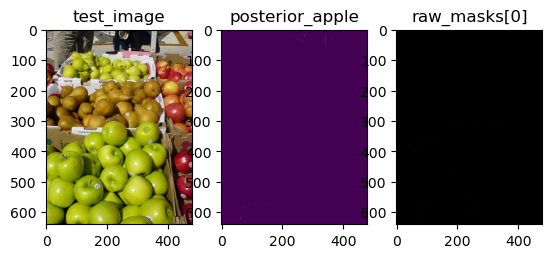

In [244]:
_ , (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(test_image)
ax1.set_title('test_image')
ax2.imshow(posterior_apple)
ax2.set_title('posterior_apple')
ax3.imshow(raw_masks[0])
ax3.set_title('raw_masks[0]')